In [65]:
# import basic modules
import sys
import os
import numpy as np

import torch

import matplotlib.pyplot as plt
import matplotlib
from copy import deepcopy

# import custom modules
root_dir   = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root_dir, 'code'))
from model_fitting import initialize_fitting
from utils import numpy_utils, texture_utils, prf_utils

In [15]:
# Set up the Gabor filtering modules (to get different sizes of feature maps)
n_ori_gabor=12;
n_sf_gabor=8;
device = 'cpu:0'

_gabor_ext_complex, _gabor_ext_simple, _fmaps_fn_complex, _fmaps_fn_simple = \
            initialize_fitting.get_gabor_feature_map_fn(n_ori_gabor, n_sf_gabor,device=device,\
            nonlin_fn=False);  
_gabor_ext_complex.get_fmaps_sizes(image_size=[240,240])
resolutions_each_sf = _gabor_ext_complex.resolutions_each_sf
resolutions_each_sf 

[13, 21, 32, 49, 77, 121, 190, 298]

In [8]:
# Params for the spatial aspect of the model (possible pRFs)
which_prf_grid=5
models = initialize_fitting.get_prf_models(which_grid=which_prf_grid)    

In [41]:
np.unique(xcoord)

array([-0.8333, -0.7699, -0.6282, -0.5893, -0.5804, -0.4682, -0.4442,
       -0.4325, -0.3433, -0.331 , -0.3189, -0.3172, -0.2459, -0.2427,
       -0.2404, -0.2272, -0.1792, -0.1739, -0.1699, -0.1569, -0.1314,
       -0.1201, -0.1105, -0.1021, -0.0941, -0.0782, -0.065 , -0.0643,
       -0.0594, -0.0454, -0.0423, -0.0282, -0.026 , -0.0246, -0.0199,
       -0.0108,  0.    ,  0.0108,  0.0199,  0.0246,  0.026 ,  0.0282,
        0.0423,  0.0454,  0.0594,  0.0643,  0.065 ,  0.0782,  0.0941,
        0.1021,  0.1105,  0.1201,  0.1314,  0.1569,  0.1699,  0.1739,
        0.1792,  0.2272,  0.2404,  0.2427,  0.2459,  0.3172,  0.3189,
        0.331 ,  0.3433,  0.4325,  0.4442,  0.4682,  0.5804,  0.5893,
        0.6282,  0.7699,  0.8333], dtype=float32)

In [90]:
xcoord = np.round(models[:,0],4)
ycoord = np.round(models[:,1],4)
ecc = np.round(np.sqrt(models[:,0]**2+models[:,1]**2),4)
size = np.round(models[:,2],4)
angle  = np.mod(np.arctan2(models[:,1], models[:,0])*180/np.pi, 360)
angle[ecc==0.0] = np.nan
angle = np.round(angle,4)
unique_ecc, ecc_inds = np.unique(ecc, return_inverse=True);
unique_size, size_inds = np.unique(size, return_inverse=True);
unique_angles, angle_inds = np.unique(angle, return_inverse=True)

11.919999733567238
11.919999733567238
11.919999733567238
11.919999733567238
11.919999733567238
11.919999733567238
11.919999733567238


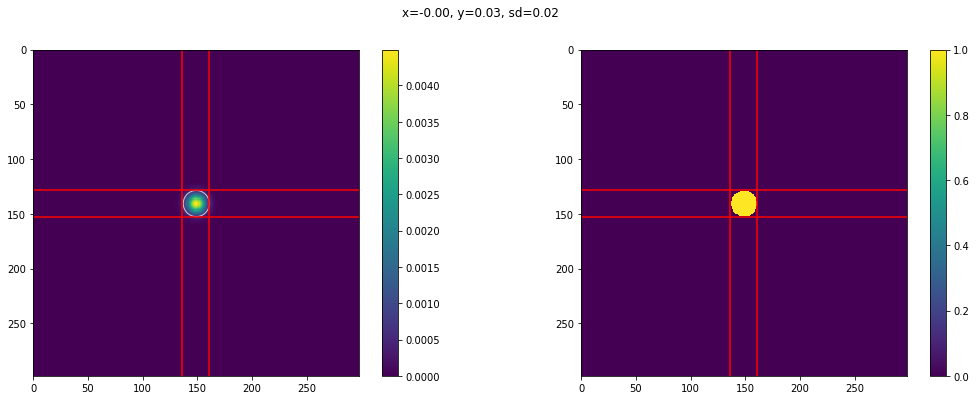

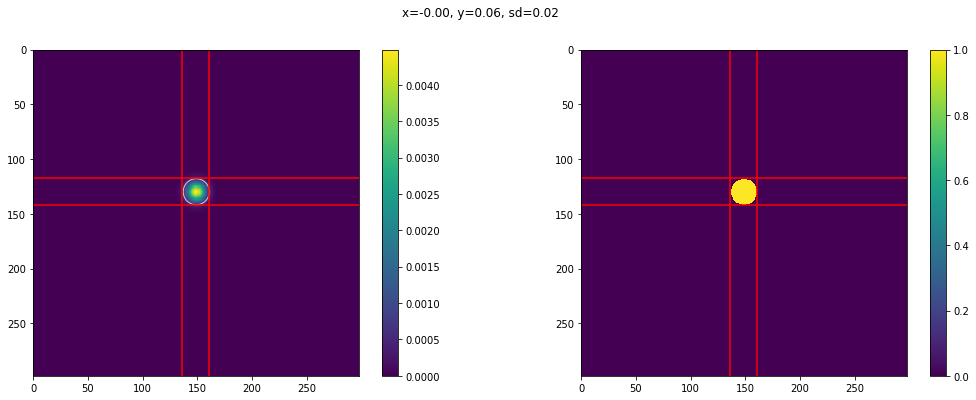

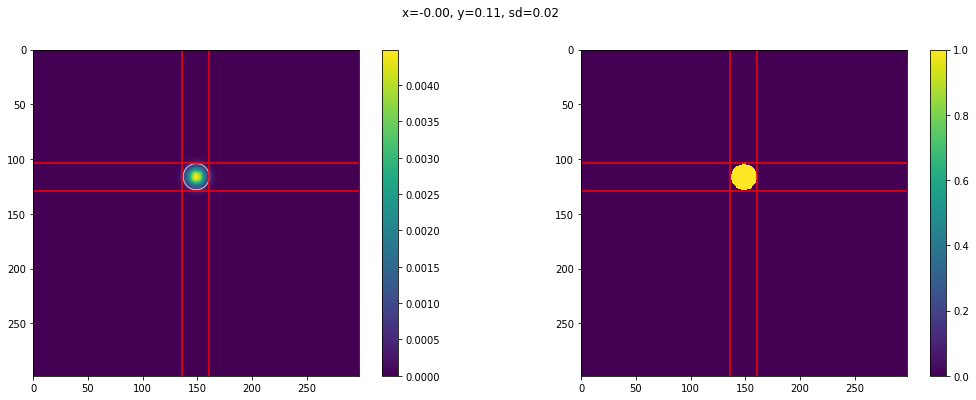

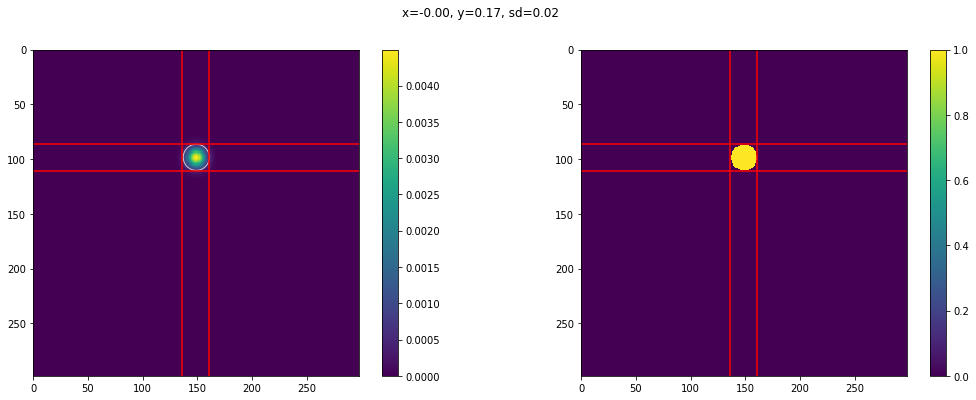

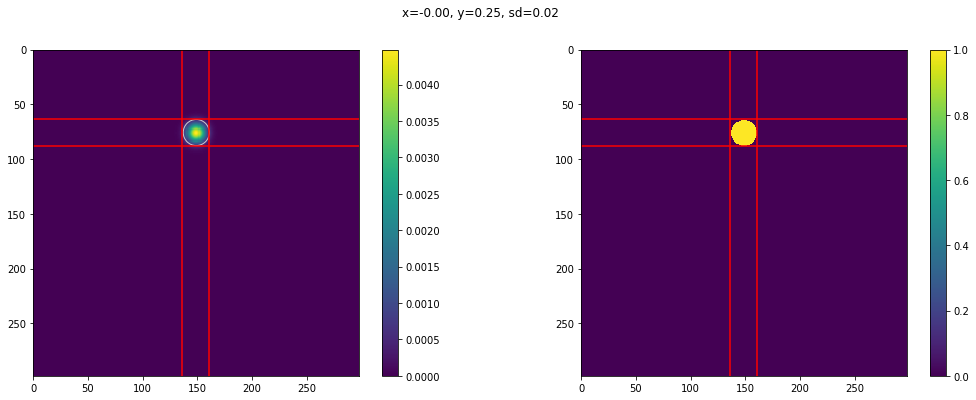

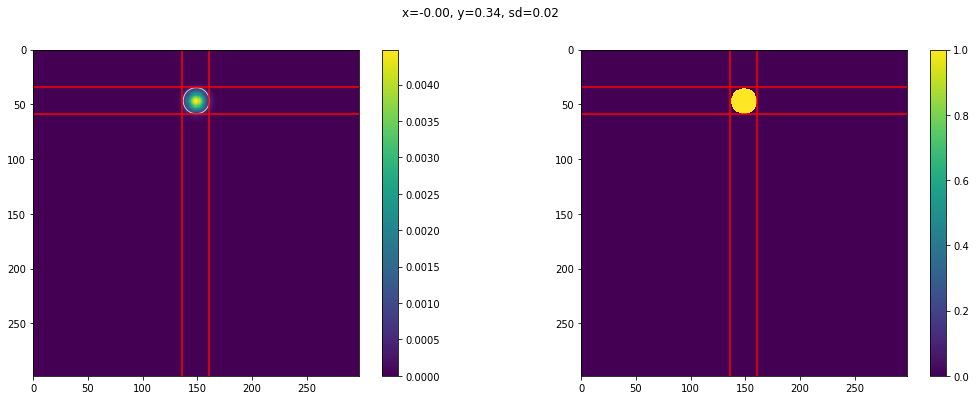

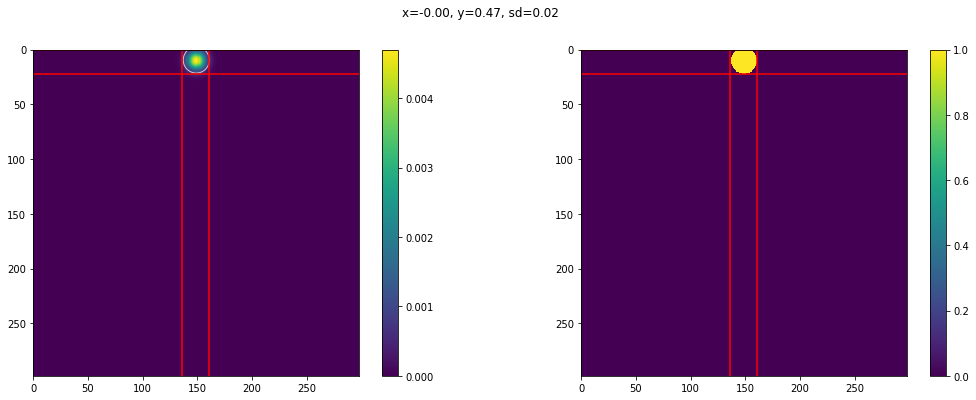

In [81]:
# visualizing some pRFs that vary only in y position from the center

inds = [[np.where((ecc_inds==ee) & (size_inds==ss) & (xcoord==0.000) & (ycoord>0))[0] \
         for ee in range(len(unique_ecc))] for ss in range(len(unique_size))]
inds = [[inds[ss][ee][0] if len(inds[ss][ee])>0 else np.nan \
            for ee in range(len(unique_ecc))] for ss in range(len(unique_size))]
inds = np.array(inds)


ff = 7;
ss = 0;
prf_inds = inds[ss,:]
n_pix = resolutions_each_sf[ff]
    
for pi, prf_ind in enumerate(prf_inds):
    
    if np.isnan(prf_ind):
        continue
    else:
        prf_ind = int(prf_ind)

    prf_params = models[prf_ind,:]    
    x,y,sigma = prf_params
  
    # center goes [row ind, col ind]
    center_pix = np.array((x*n_pix + n_pix/2, n_pix/2  - y*n_pix))
#     center_pix = np.array((n_pix/2  - y*n_pix, x*n_pix + n_pix/2)) 
    # note that the x/y dims get swapped here because of how pRF parameters are defined.
    size_pix = sigma*2*n_pix
    print(size_pix)
    aperture=1.0
    prf = prf_utils.gauss_2d(center=[x, y], sd=sigma, patch_size=n_pix, aperture=1.0, \
                                          dtype=np.float32)
    n_prf_sd_out = 2
    prf_bbox = texture_utils.get_bbox_from_prf(prf_params, (n_pix, n_pix), n_prf_sd_out, \
                                                       min_pix=None, verbose=False, force_square=False)
    [xmin, xmax, ymin, ymax] = prf_bbox

    # Creating a mask 2 SD from the center
    # cutoff of 0.14 approximates +/-2 SDs
    prf_mask = prf/np.max(prf)>0.14

    plt.figure(figsize=(18,6));
    ax = plt.subplot(1,2,1)
    plt.pcolormesh(prf)
    plt.axis('square')
    # plt.xticks(np.arange(0,n_pix)+0.5,np.arange(0,n_pix))
    # plt.yticks(np.arange(0,n_pix)+0.5,np.arange(0,n_pix))
    plt.gca().invert_yaxis()
    # show the prf on top to make sure it is where it should be
    plt.axhline([prf_bbox[0]],color='r')
    plt.axhline([prf_bbox[1]],color='r')
    plt.axvline([prf_bbox[2]],color='r')
    plt.axvline([prf_bbox[3]],color='r')
    circ = matplotlib.patches.Circle((center_pix[0],center_pix[1]),size_pix, 
                                                 color = [0.8, 0.8, 0.8], fill=False)
    ax.add_artist(circ)
    plt.colorbar()
    
    plt.subplot(1,2,2)
    plt.pcolormesh(prf_mask)
    plt.axis('square')
    # plt.colorbar()
    plt.gca().invert_yaxis()
    # show the prf on top to make sure it is where it should be
    plt.axhline([prf_bbox[0]],color='r')
    plt.axhline([prf_bbox[1]],color='r')
    plt.axvline([prf_bbox[2]],color='r')
    plt.axvline([prf_bbox[3]],color='r')

    plt.suptitle('x=%.2f, y=%.2f, sd=%.2f'%(x,y,sigma))
    plt.colorbar()
    

385.89737606048584
385.89737606048584
385.89737606048584
385.89737606048584
385.89737606048584
385.89737606048584
385.89737606048584
385.89737606048584
385.89737606048584


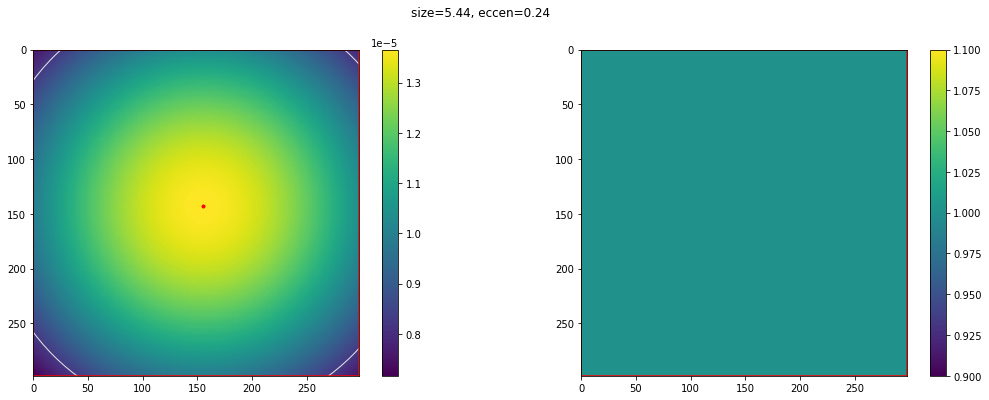

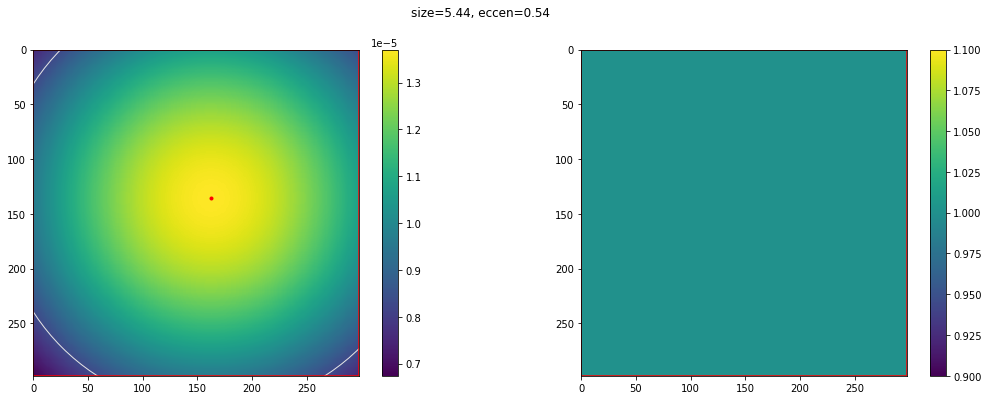

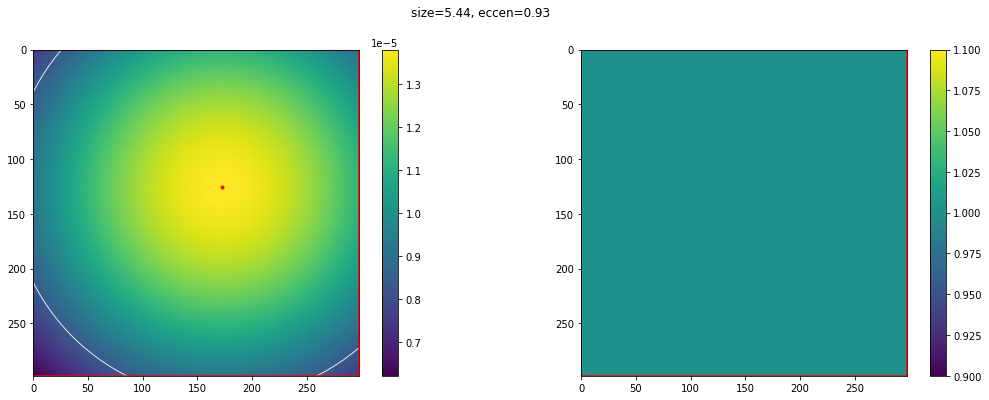

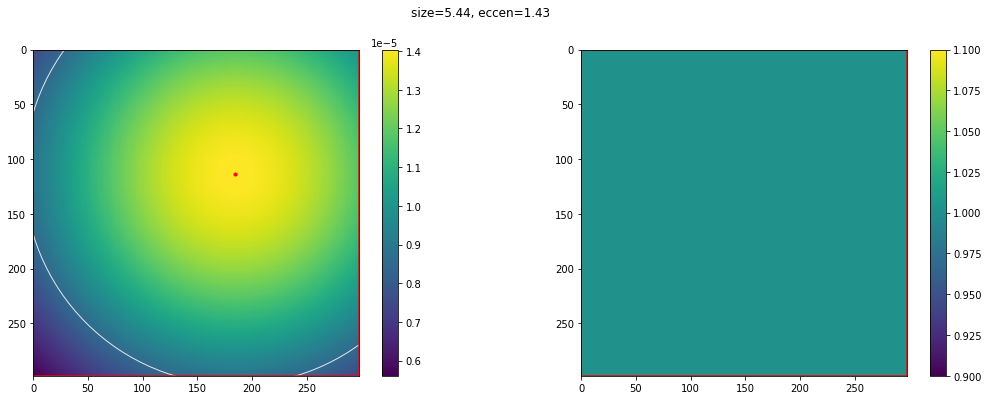

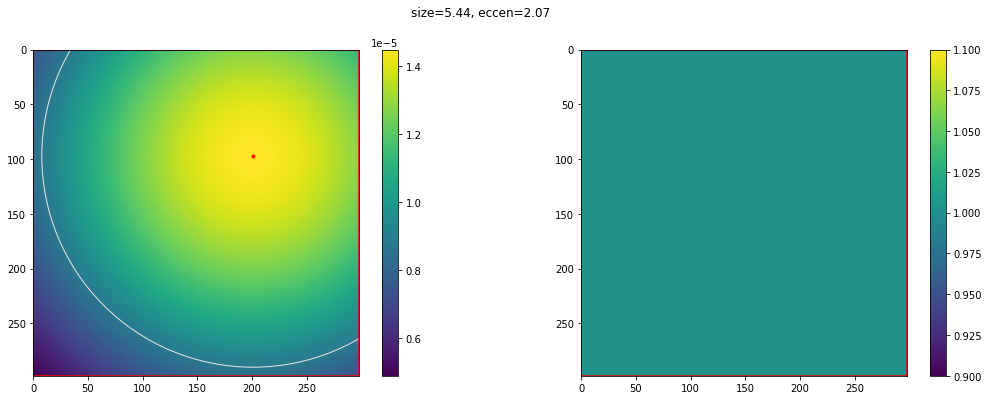

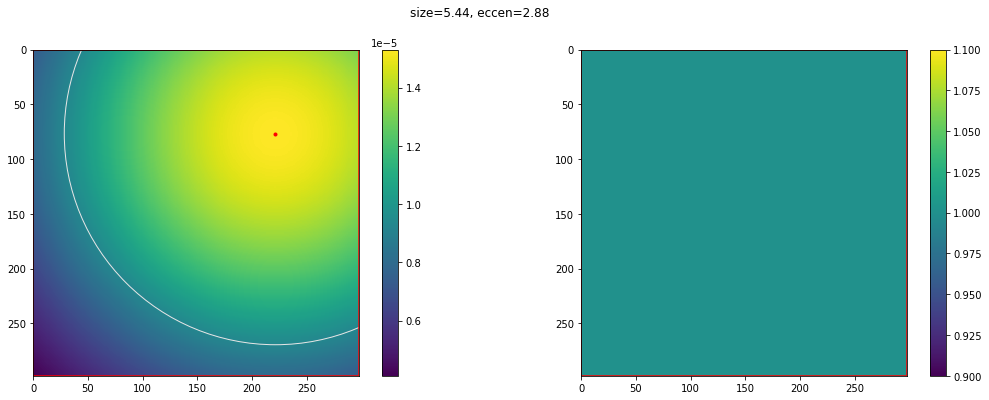

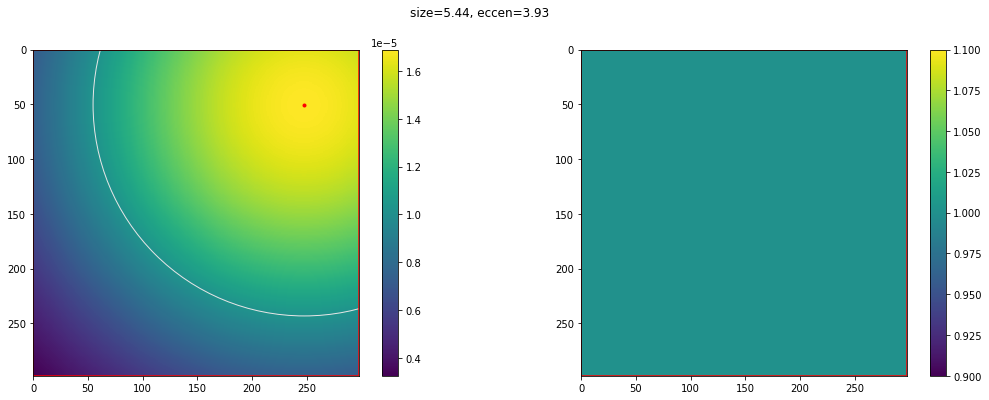

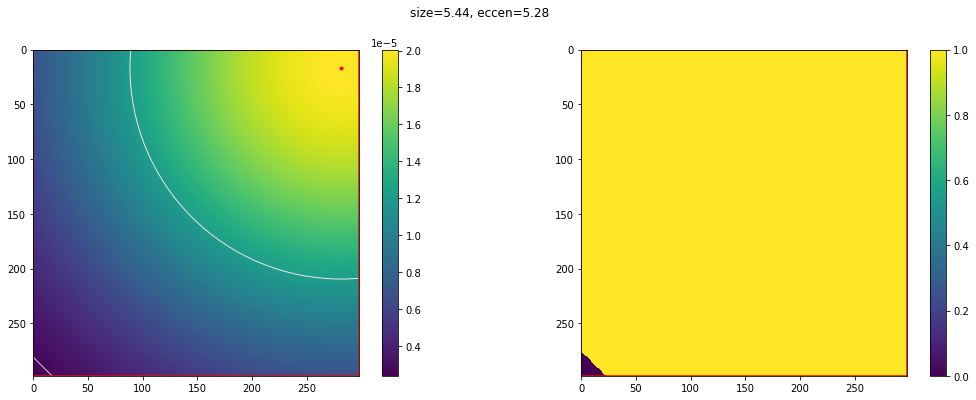

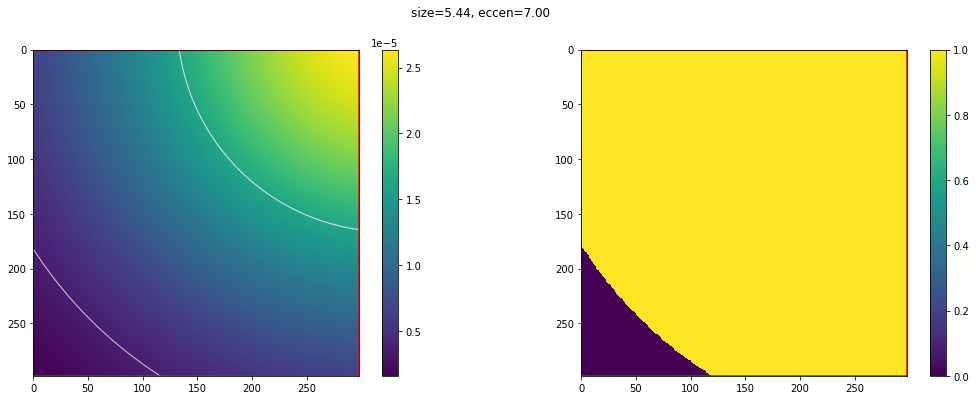

In [105]:
# visualizing some pRFs that vary along diagonal line from the center 

aa = np.where(unique_angles==45)[0][0]
inds = [[np.where((ecc_inds==ee) & (size_inds==ss) & (angle_inds==aa))[0] \
         for ee in range(len(unique_ecc))] for ss in range(len(unique_size))]
inds = [[inds[ss][ee][0] if len(inds[ss][ee])>0 else np.nan \
            for ee in range(len(unique_ecc))] for ss in range(len(unique_size))]
inds = np.array(inds)

ff = 7;
ss = 8;
prf_inds = inds[ss,:]
n_pix = resolutions_each_sf[ff]
    
for pi, prf_ind in enumerate(prf_inds):
    
    if np.isnan(prf_ind):
        continue
    else:
        prf_ind = int(prf_ind)

    prf_params = models[prf_ind,:]    
    x,y,sigma = prf_params
  
    # center goes [row ind, col ind]
    center_pix = np.array((x*n_pix + n_pix/2, n_pix/2  - y*n_pix))
#     center_pix = np.array((n_pix/2  - y*n_pix, x*n_pix + n_pix/2)) 
    # note that the x/y dims get swapped here because of how pRF parameters are defined.
    size_pix = sigma*2*n_pix
    print(size_pix)
    aperture=1.0
    prf = prf_utils.gauss_2d(center=[x, y], sd=sigma, patch_size=n_pix, aperture=1.0, \
                                          dtype=np.float32)
    n_prf_sd_out = 2
    prf_bbox = texture_utils.get_bbox_from_prf(prf_params, (n_pix, n_pix), n_prf_sd_out, \
                                                       min_pix=None, verbose=False, force_square=False)
    [xmin, xmax, ymin, ymax] = prf_bbox

    # Creating a mask 2 SD from the center
    # cutoff of 0.14 approximates +/-2 SDs
    prf_mask = prf/np.max(prf)>0.14

    plt.figure(figsize=(18,6));
    ax = plt.subplot(1,2,1)
    plt.pcolormesh(prf)
    plt.axis('square')
    # plt.xticks(np.arange(0,n_pix)+0.5,np.arange(0,n_pix))
    # plt.yticks(np.arange(0,n_pix)+0.5,np.arange(0,n_pix))
    plt.gca().invert_yaxis()
    # show the prf on top to make sure it is where it should be
    plt.axhline([prf_bbox[0]],color='r')
    plt.axhline([prf_bbox[1]],color='r')
    plt.axvline([prf_bbox[2]],color='r')
    plt.axvline([prf_bbox[3]],color='r')
    circ = matplotlib.patches.Circle((center_pix[0],center_pix[1]),size_pix/2, 
                                                 color = [0.9, 0.9, 0.9], fill=False)
    ax.add_artist(circ)
    circ = matplotlib.patches.Circle((center_pix[0],center_pix[1]),size_pix, 
                                                 color = [0.8, 0.8, 0.8], fill=False)
    ax.add_artist(circ)
    plt.colorbar()
    plt.plot(center_pix[0], center_pix[1], '.',color='r')
    plt.subplot(1,2,2)
    plt.pcolormesh(prf_mask)
    plt.axis('square')
    # plt.colorbar()
    plt.gca().invert_yaxis()
    # show the prf on top to make sure it is where it should be
    plt.axhline([prf_bbox[0]],color='r')
    plt.axhline([prf_bbox[1]],color='r')
    plt.axvline([prf_bbox[2]],color='r')
    plt.axvline([prf_bbox[3]],color='r')

    size_deg = sigma*8.4;
    eccen_deg = np.sqrt(x**2+y**2)*8.4
    plt.suptitle('size=%.2f, eccen=%.2f'%(size_deg, eccen_deg))
#     plt.suptitle('x=%.2f, y=%.2f, sd=%.2f'%(x,y,sigma))
    plt.colorbar()
    

161.77928757667542
161.77928757667542
161.77928757667542
161.77928757667542
161.77928757667542
161.77928757667542
161.77928757667542
161.77928757667542
161.77928757667542


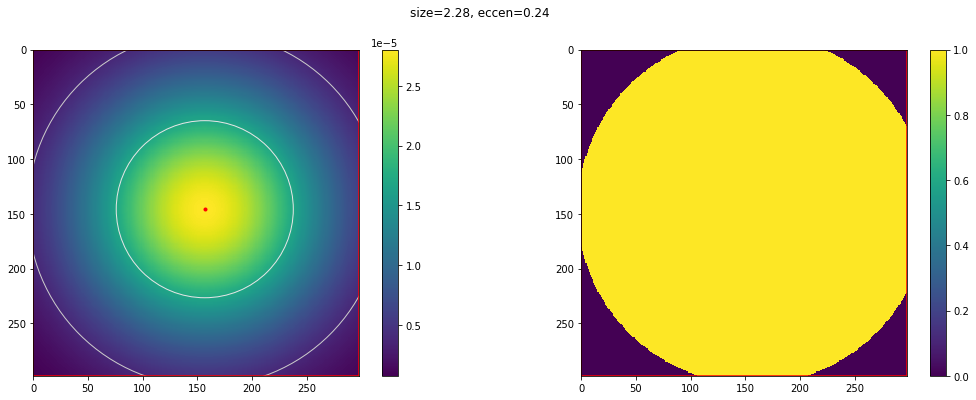

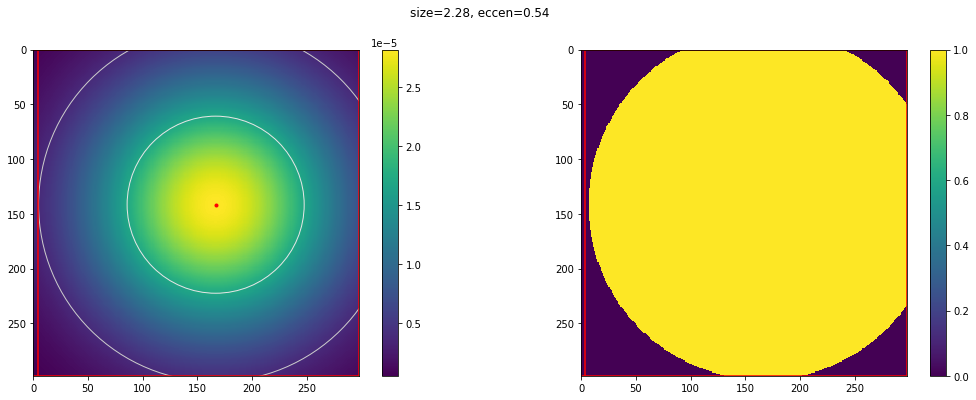

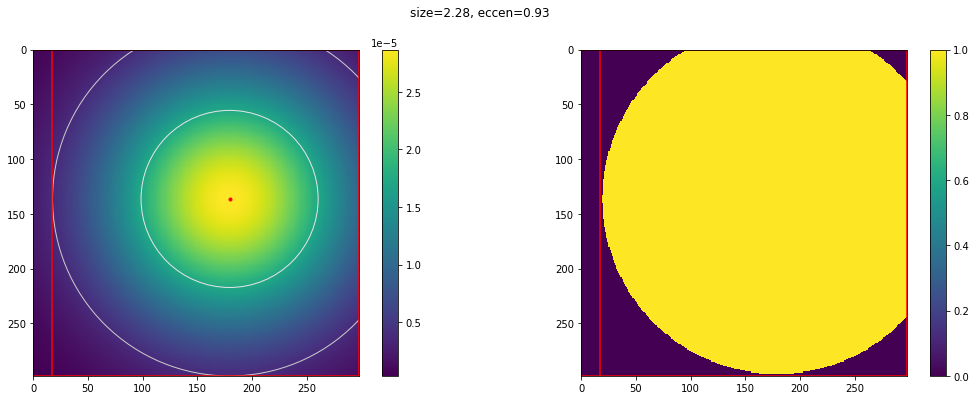

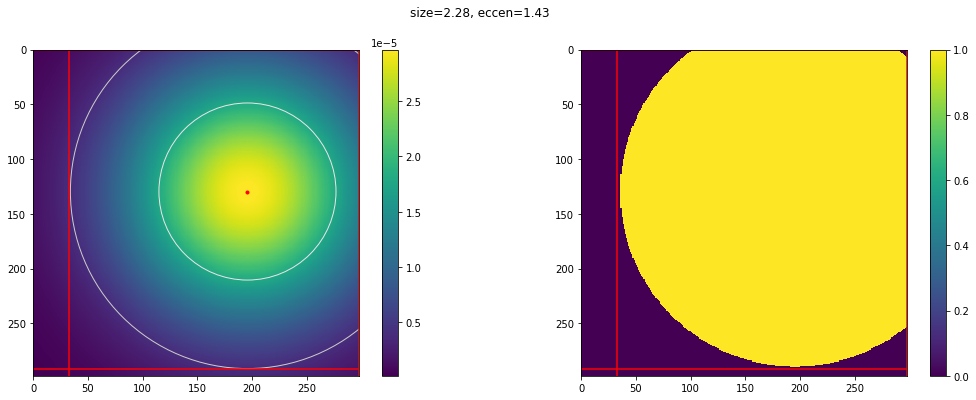

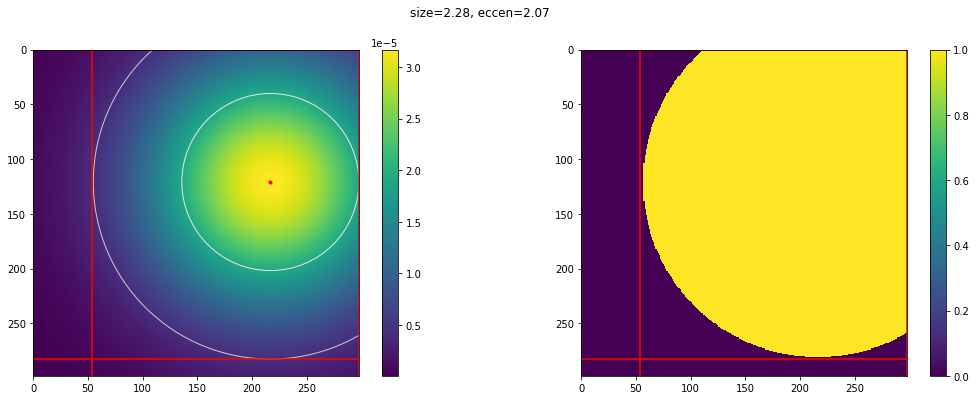

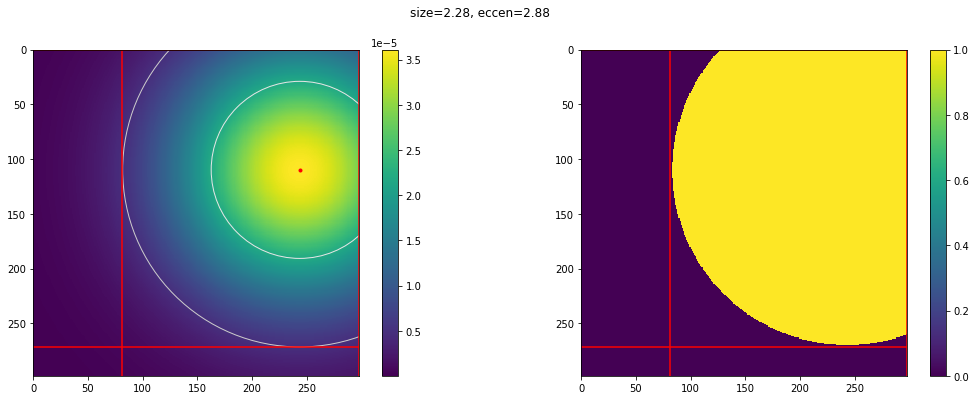

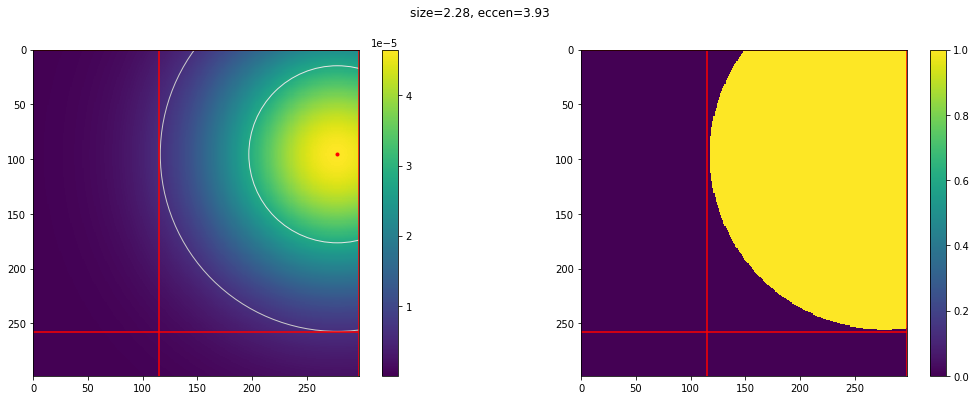

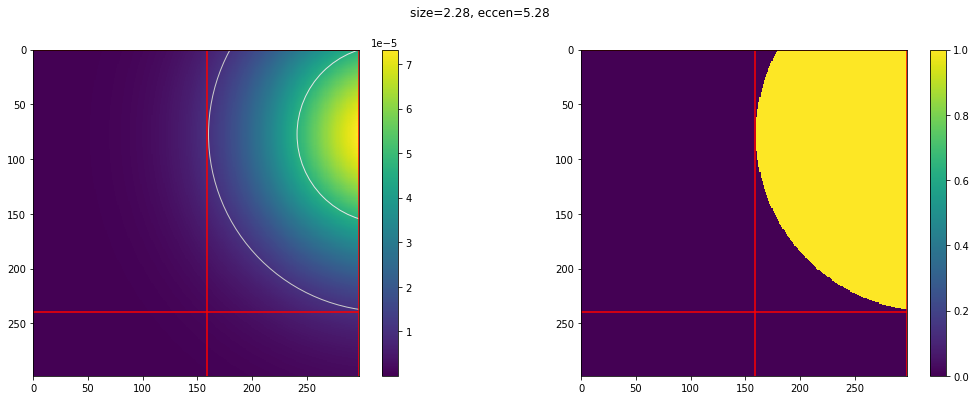

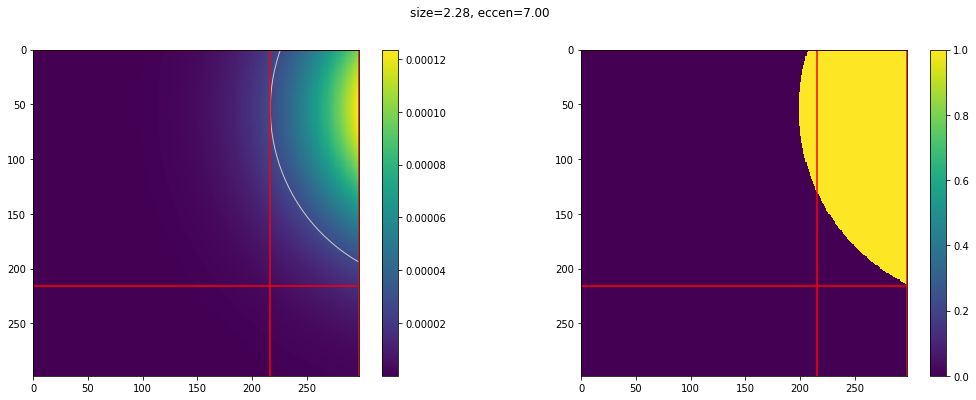

In [107]:
# visualizing some pRFs that vary along diagonal line from the center 

aa = np.where(unique_angles==22.5)[0][0]
inds = [[np.where((ecc_inds==ee) & (size_inds==ss) & (angle_inds==aa))[0] \
         for ee in range(len(unique_ecc))] for ss in range(len(unique_size))]
inds = [[inds[ss][ee][0] if len(inds[ss][ee])>0 else np.nan \
            for ee in range(len(unique_ecc))] for ss in range(len(unique_size))]
inds = np.array(inds)

ff = 7;
ss = 6;
prf_inds = inds[ss,:]
n_pix = resolutions_each_sf[ff]
    
for pi, prf_ind in enumerate(prf_inds):
    
    if np.isnan(prf_ind):
        continue
    else:
        prf_ind = int(prf_ind)

    prf_params = models[prf_ind,:]    
    x,y,sigma = prf_params
  
    # center goes [row ind, col ind]
    center_pix = np.array((x*n_pix + n_pix/2, n_pix/2  - y*n_pix))
#     center_pix = np.array((n_pix/2  - y*n_pix, x*n_pix + n_pix/2)) 
    # note that the x/y dims get swapped here because of how pRF parameters are defined.
    size_pix = sigma*2*n_pix
    print(size_pix)
    aperture=1.0
    prf = prf_utils.gauss_2d(center=[x, y], sd=sigma, patch_size=n_pix, aperture=1.0, \
                                          dtype=np.float32)
    n_prf_sd_out = 2
    prf_bbox = texture_utils.get_bbox_from_prf(prf_params, (n_pix, n_pix), n_prf_sd_out, \
                                                       min_pix=None, verbose=False, force_square=False)
    [xmin, xmax, ymin, ymax] = prf_bbox

    # Creating a mask 2 SD from the center
    # cutoff of 0.14 approximates +/-2 SDs
    prf_mask = prf/np.max(prf)>0.14

    plt.figure(figsize=(18,6));
    ax = plt.subplot(1,2,1)
    plt.pcolormesh(prf)
    plt.axis('square')
    # plt.xticks(np.arange(0,n_pix)+0.5,np.arange(0,n_pix))
    # plt.yticks(np.arange(0,n_pix)+0.5,np.arange(0,n_pix))
    plt.gca().invert_yaxis()
    # show the prf on top to make sure it is where it should be
    plt.axhline([prf_bbox[0]],color='r')
    plt.axhline([prf_bbox[1]],color='r')
    plt.axvline([prf_bbox[2]],color='r')
    plt.axvline([prf_bbox[3]],color='r')
    circ = matplotlib.patches.Circle((center_pix[0],center_pix[1]),size_pix/2, 
                                                 color = [0.9, 0.9, 0.9], fill=False)
    ax.add_artist(circ)
    circ = matplotlib.patches.Circle((center_pix[0],center_pix[1]),size_pix, 
                                                 color = [0.8, 0.8, 0.8], fill=False)
    ax.add_artist(circ)
    plt.colorbar()
    plt.plot(center_pix[0], center_pix[1], '.',color='r')
    plt.subplot(1,2,2)
    plt.pcolormesh(prf_mask)
    plt.axis('square')
    # plt.colorbar()
    plt.gca().invert_yaxis()
    # show the prf on top to make sure it is where it should be
    plt.axhline([prf_bbox[0]],color='r')
    plt.axhline([prf_bbox[1]],color='r')
    plt.axvline([prf_bbox[2]],color='r')
    plt.axvline([prf_bbox[3]],color='r')

    size_deg = sigma*8.4;
    eccen_deg = np.sqrt(x**2+y**2)*8.4
    plt.suptitle('size=%.2f, eccen=%.2f'%(size_deg, eccen_deg))
#     plt.suptitle('x=%.2f, y=%.2f, sd=%.2f'%(x,y,sigma))
    plt.colorbar()
    